In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
xray_url = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia'
od.download(xray_url)

Skipping, found downloaded files in "./chest-xray-pneumonia" (use force=True to force download)


In [ ]:
import os 

In [ ]:
# This time, I will try to train the network only on images in which the person has pneumonia
# the directory contains only pneumonia images

DATA_DIR = './train'
print(os.listdir(DATA_DIR))

['PNEUMONIA', '.DS_Store']


In [ ]:
# this folder was making problems and I was not able to delete it as usual, so this is a fix from the internet

# os.rmdir('/content/train/.ipynb_checkpoints')

In [ ]:
print(os.listdir(DATA_DIR))

['PNEUMONIA', '.DS_Store']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

image_size = 64
batch_size = 5
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, max=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:max]), nrow=8).permute(1, 2, 0))

def show_batch(dl, max=64):
    for images, _ in dl:
        show_images(images, max)
        break

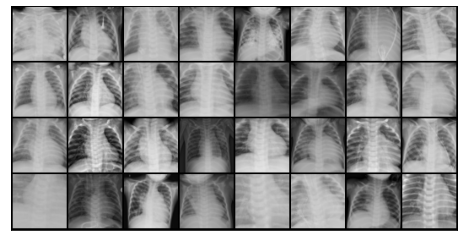

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [ ]:
#function to generate one image

# xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
# fake_images = generator(xb)
# print(fake_images.shape)
# show_images(fake_images)

In [ ]:
# fake_images.type

In [ ]:
generator = to_device(generator, device)

In [ ]:
import torch.nn.functional as F

In [ ]:
def train_discriminator(real_images, opt_d):
  opt_d.zero_grad()

  # real images to the discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0),1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  #generate fake imgs
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  #pass fakes to the discriminator
  fake_preds = discriminator(fake_images)
  fake_targets = torch.zeros(fake_images.size(0),1, device=device)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  #update the weights for discriminator
  loss = real_loss + fake_loss
  loss = to_device(loss, device)
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
  opt_g.zero_grad()

  # generate fakes
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  #pass fakes to the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device = device)
  loss = F.binary_cross_entropy(preds, targets)
  loss = to_device(loss, device)

  #update weights for the gen
  loss.backward()
  opt_g.step()

  return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated_pneumonia'
os.makedirs(sample_dir, exist_ok = True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'gen_pneum_{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
# testing the save__examples funtion. it always works.

# save_samples(0, fixed_latent)

In [ ]:
# simple progress bar

from tqdm.notebook import tqdm

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=True)

        
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
# I changed the learning rate to 5 times smaller

lr = 0.0002
epochs = 25

In [ ]:
history = fit(epochs, lr)

In [ ]:
# I wanted to know how many images are there in this directory because Colab was not showing everything and I was afraid
# that the training dataset is too small, since the results were really not good

# folder path
NEW_DIR = './train/PNEUMONIA'

dir_path = NEW_DIR
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count: {0}'.format(count))

File count: 3876


In [ ]:
# saving the model parameters so that we can continue training

torch.save(generator.state_dict(), 'xray_pneumonia_1_G.pth')
torch.save(discriminator.state_dict(), 'xray_pneumonia_1_D.pth')

In [ ]:
import cv2
import os

vid_fname = 'xray_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

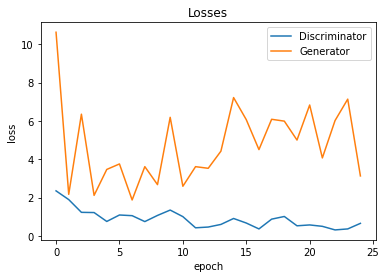

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

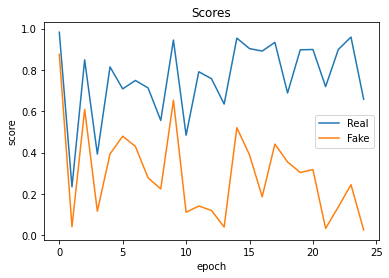

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
from statistics import mean

In [ ]:
avg_fake = mean(fake_scores)
avg_real = mean(real_scores)
print('The average fake score is {0}'.format(avg_fake))
print('The average real scores is {0}'.format(avg_real))

The average fake score is 0.2983953112363815
The average real scores is 0.7604147452116012


In [ ]:
# displaying images with Pillow


# from PIL import Image


# im = Image.open("/content/generated/generated-images-0000.png")
# im.show()

In [ ]:
# displaying images with PLT

# import matplotlib.image as mpimg
# img = mpimg.imread('/content/generated/generated-images-0019.png')
# imgplot = plt.imshow(img)
# plt.show()